# Pre-Processing
In the Preprocessing stage, I will first split the dataset into training and testing sets to ensure that the models can be properly trained and evaluated on separate data. The training set is used to fit and optimize the supervised classification models, while the testing set is reserved for assessing their predictive performance.  

Next, I create preprocessing pipelines for both numeric and categorical features. The numeric transformer uses an `SimpleImputer` to fill in missing values based on the medians of the numeric variables, followed by a `StandardScaler` to normalize their ranges. The categorical transformer also uses an `SimpleImputer` with the most frequent category strategy to handle missing values and then applies a `OneHotEncoder` to convert categorical features into numerical format suitable for modeling. These transformations are combined within a `ColumnTransformer` to ensure that each feature type is processed appropriately and consistently, producing a clean and fully prepared dataset for model training.

### Import Python Packages & Dataset

In [1]:
import pandas as pd
import numpy as np
import os
import joblib

from sklearn.pipeline import Pipeline  as SkPipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()

# Import dataset that was created in the '5509_income_pre_modeling.ipynb' workbook
df = pd.read_csv('./df.csv')

# Downcast floats datatypes to minimize memory usage 
for col in df.select_dtypes(include=['float64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='float')

# Downcast interger datatypes to minimize memory usage 
for col in df.select_dtypes(include=['int64']).columns:
    df[col] = pd.to_numeric(df[col], downcast='integer')

# Instantiate an empty dataframe that will be used to store each models precision, recall, and F1 scores by target category
model_results_df = pd.DataFrame([])

# Instantiate an empty dataframe that will be used to store each models AUC
model_roc_auc_df = pd.DataFrame([])

# Define column types
categorical_columns = [
    'workclass',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
    'income'
 ]
numeric_columns = [
    'age',
    'fnlwgt',
    'education-num',
    'capital-gain',
    'capital-loss',
    'hours-per-week'
 ]

### Train Test Split
- The dataset is now divided into a training set that will be used to build supervised classification models, and a testing set for evaluating their performance.

In [2]:
# Define the predictors
X = df[['age', 'workclass', 'fnlwgt', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country']]

# Define the target
y = df['income']

# Drop the target from the categorical_columns list
categorical_columns = [col for col in categorical_columns if col != 'income']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Check shape of X_train, X_test, y_train, & y_test
print(f'X_train shape = {X_train.shape}    y_train shape = {y_train.shape}')
print(f'X_test shape =  {X_test.shape}     y_test shape =  {y_test.shape}')

X_train shape = (39050, 13)    y_train shape = (39050,)
X_test shape =  (9763, 13)     y_test shape =  (9763,)


### Preprocessing Transformers
- Next we build a preprocessing pipeline that prepares numeric and categorical data for modeling. Numeric features are imputed using their median values and standardized for consistent scaling, while categorical features are imputed with the most frequent category and one-hot encoded into binary variables. The `ColumnTransformer` then applies these transformations to their respective columns, producing a clean, model-ready dataset.
- To aid in modeling dummy columns will be added during imputing to indicate where data was missing for the `capital-gain`, `capital-loss`, `workclass`, `occupation`, and `native-country` columns.

In [3]:
numeric_transformer = SkPipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler())
])

categorical_transformer = SkPipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'
)

### Preprocessing - Conclusions/Discussions/Next Steps:
During preprocessing, the main challenge identified was ensuring that the imputation process accurately captured relationships among variables without introducing bias, especially given the number of missing values in both numeric and categorical features.  

With the data now standardized and encoded, the next step will be to apply supervised learning models to classify `income` levels and evaluate their performance on the testing set.

# Base Classifiers Modeling
In the Modeling section, I first define several helper functions to streamline the evaluation process by generating learning curves, classification reports, confusion matrices, ROC curves, and feature selection summaries.  

Three supervised classification models are developed:
- a Logistic Regression model to estimate class probabilities using a sigmoid function,
- a Support Vector Classifier (SVC) to separate classes by finding the optimal decision boundary, and
- a Random Forest Classifier to aggregate multiple decision trees for improved accuracy and robustness.

Each model is trained using the preprocessed training data and evaluated on the test set to measure performance.  

Finally, ROC curves are plotted to compare all three classifiers and visually assess their ability to distinguish between `income` classes.

### Modeling Helper Functions
- These helper functions are used to evaluate model performance by:
  - Fitting the model (`fit_model` function)
  - Plotting the learning curve plots (`plot_learning_curve` function)
  - Generating classification tables and confusion matrices (`create_classification_output` function)
  - Plot ROC curves (`make_roc_curves` function)
- There are also functions used to:
  - Identify dropped columns during feature selection (`showdropped_features` function)
  - Extract the best hyperparameters from cross-validation (`best_params_for` function)

In [4]:
# Function to check if a model has already been fit then load the model, otherwise fit the model
def fit_model(pipe, X_train, y_train, filename):
    if os.path.exists(filename):
        print(f'Loading saved model from {filename}')
        fitted_model = joblib.load(filename)
    else:
        fitted_model = pipe.fit(X_train, y_train)
        joblib.dump(fitted_model, filename)
        print(f'Model fitted and saved to {filename}')
    return fitted_model

# Function to plot the learning curve for a given model
def plot_learning_curve(estimator, X, y, clf_type):
    print('\n' + '=' * 110)
    print(f'{clf_type} Learning Curve:')
    train_sizes, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=np.linspace(0.2, 1.0, 5),
        shuffle=True,
        random_state=42,
        # verbose=3
    )
    train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
    val_mean, val_std = val_scores.mean(axis=1), val_scores.std(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_mean, 'o-', label='Training')
    plt.plot(train_sizes, val_mean, 'o-', label='Validation')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1)
    plt.xlabel('Training set size')
    plt.ylabel('ROC AUC')
    plt.title(f'Learning Curve (ROC AUC)\n({clf_type})')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# Function to output the classification report and confusion matrix for a given model
def create_classification_output(pipe, y_test, y_pred, clf_type):
    # Create classification report
    print('\n' + '=' * 110)
    print(f'{clf_type} Report:\n{classification_report(y_test, y_pred, digits=4)}')
    report = classification_report(y_test, y_pred, digits=4, output_dict=True)

    # Append model results to the model_results_df
    temp_result_df = pd.DataFrame.from_dict(
        {k:v for k,v in report.items() if k in ['<=50K', '>50K']},
        orient='index'
    ).reset_index(names='income')
    temp_result_df['model'] = clf_type
    global model_results_df
    model_results_df = pd.concat([model_results_df, temp_result_df])
    # Append model roc_auc to the model_roc_auc_df
    if hasattr(pipe, 'predict_proba'):
        print(hasattr(pipe, 'predict_proba'))   
        y_score = pipe.predict_proba(X_test)[:, 1]
    else:
        y_score = pipe.decision_function(X_test)
    auc = roc_auc_score(y_test, y_score)
    print(f'The {clf_type} ROC AUC = {auc:.4f}')
    temp_roc_auc_df = pd.DataFrame.from_dict(
            {clf_type:auc},
            orient='index',
            columns=['roc_auc']
        ).reset_index(names='model')
    global model_roc_auc_df
    model_roc_auc_df = pd.concat([model_roc_auc_df, temp_roc_auc_df])

    # Plot confusion matrix
    print('\n' + '=' * 110)
    print(f'{clf_type} Confusion Matrix:')
    labels = ['<=50K', '>50K']
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Test Data Confusion Matrix\n({clf_type})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Function to plot ROC curves and a AUC summary chart to compare models
def make_roc_curves(X_test, y_test, models):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1]})
    aucs, colors = {}, {}

    for name, model in models.items():
        if hasattr(model, 'predict_proba'):
            y_score = model.predict_proba(X_test)[:, 1]
        else:
            y_score = model.decision_function(X_test)
        aucs[name] = roc_auc_score(y_test, y_score)
        disp = RocCurveDisplay.from_predictions(y_test, y_score, name=name, ax=ax1, pos_label='>50K')
        colors[name] = disp.line_.get_color()

    # ROC Curves
    ax1.plot([0, 1], [0, 1], 'k--', label='Chance')
    ax1.set_title('ROC Curves')
    ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1, frameon=False, fontsize=9)

    # AUC Summary Chart
    names, scores = zip(*sorted(aucs.items(), key=lambda kv: kv[1], reverse=True))
    bar_colors = [colors[n] for n in names]
    bars = ax2.bar(range(len(names)), scores, color=bar_colors)
    ax2.set_xticks(range(len(names)))
    ax2.set_xticklabels(names, rotation=90, ha='center')
    ax2.set_ylabel('AUC'); ax2.set_ylim(0.8, 1.0); ax2.set_title('AUC by Model Type')
    for rect, s in zip(bars, scores):
        ax2.text(rect.get_x() + rect.get_width()/2.0, rect.get_height() + 0.005, f'{s:.3f}',
                 ha='center', va='bottom', fontsize=9)
    fig.tight_layout(); fig.subplots_adjust(bottom=0.25)
    plt.show()

# Function to show which features are being dropped during feature selection
def show_dropped_features(pipe, clf_type):
    preprocess = pipe.named_steps['preprocessor']
    selector = pipe.named_steps['selector']

    feature_names = preprocess.get_feature_names_out()
    kept_mask = selector.get_support()
    coef = getattr(selector.estimator_, 'coef_', None)
    l1_importance = np.abs(coef).ravel() if coef is not None else np.zeros_like(kept_mask, dtype=float)

    selector_df = (
        pd.DataFrame({
            'feature': feature_names,
            'kept': kept_mask,
            'l1_importance': l1_importance
        })
        .assign(status=lambda d: np.where(d.kept, 'kept', 'dropped'))
        .sort_values(['kept', 'l1_importance'], ascending=[False, False])
        .reset_index(drop=True)
    )

    print('=' * 110)
    print(f'{clf_type} Feature Selection:')
    print(f'\n{kept_mask.sum()} of the {kept_mask.size} features are used in modeling\n')
    print('Features dropped from model:')
    for feat in selector_df.loc[~selector_df['kept'], 'feature']:
        print(f'\t{feat}')

# Function to extract the best model hyperparameters from cross-validation
def best_params_for(results, name):
    mask = results['param_classifier'].astype(str).str.contains(name)
    row = results[mask].sort_values('rank_test_score').iloc[0].dropna()
    params = {k: row[k] for k in row.index if k.startswith('param_')}
    params = {k.replace('param_', ''): v for k, v in params.items()}
    return params

### Logistic Classifier
- A Logistic Classifier predicts the probability that an observation belongs to a particular class by modeling the relationship between input features and a binary outcome using a logistic (sigmoid) function.

Model fitted and saved to logistic_pipe.pkl

Logistic Classification (base model) Learning Curve:


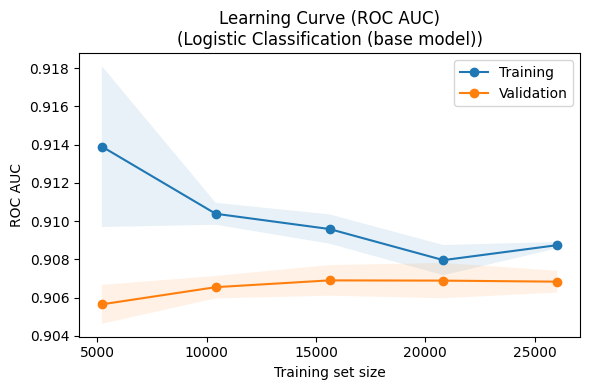


Logistic Classification (base model) Report:
              precision    recall  f1-score   support

       <=50K     0.8833    0.9375    0.9096      7426
        >50K     0.7533    0.6063    0.6719      2337

    accuracy                         0.8582      9763
   macro avg     0.8183    0.7719    0.7907      9763
weighted avg     0.8522    0.8582    0.8527      9763

True
The Logistic Classification (base model) ROC AUC = 0.9082

Logistic Classification (base model) Confusion Matrix:


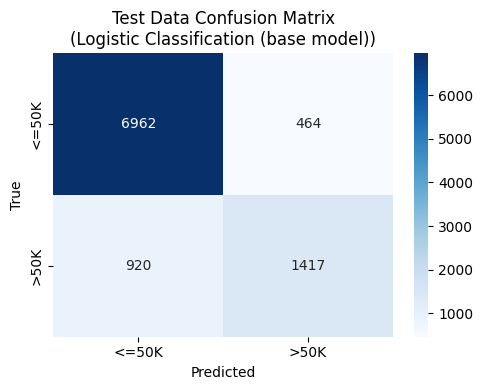

In [5]:
# Define classifier type
clf_type = 'Logistic Classification (base model)'

# Create logistic classifier pipeline instance
logistic_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_pipe = fit_model(logistic_pipe, X_train, y_train, 'logistic_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_pipe.predict(X_test)

# Create classification output
create_classification_output(logistic_pipe, y_test, y_pred, clf_type)

> The Logistic Classification base model achieved solid performance with an ROC AUC of 0.908, an overall accuracy of 85.8%, and strong recall for the <=50K class (93.8%), though it underperformed on the >50K class (recall = 60.6%). The learning curve suggests mild overfitting but stable generalization as the training size increases.

### Support Vector Classifier
- A Support Vector Classifier (SVC) separates classes by finding the optimal hyperplane that maximizes the margin between them, making it effective for both linear and non-linear classification problems.

In [ ]:
# Define classifier type
clf_type = 'Support Vector Classifier (base model)'

# Create logistic classifier pipeline instance
svc_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True, cache_size=4096, random_state=42))
])

# Fit model
svc_pipe = fit_model(svc_pipe, X_train, y_train, 'svc_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_pipe, y_test, y_pred, clf_type)

> The Support Vector Classifier base model produced an ROC AUC of 0.907 and overall accuracy of 85.7%, nearly identical to the logistic model. It maintained high recall for the <=50K class (93.9%) but continued to struggle with the >50K class (recall = 59.6%), indicating mild overfitting but consistent and reliable generalization performance.

### Random Forest Classifier
- A Random Forest Classifier builds an ensemble of decision trees on random subsets of the data and averages their predictions to improve accuracy and reduce overfitting.

In [ ]:
# Define classifier type
clf_type = 'Random Forest Classifier (base model)'

# Create random forest classifier pipeline instance
rf_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_pipe = fit_model(rf_pipe, X_train, y_train, 'rf_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_pipe.predict(X_test)

# Create classification output
create_classification_output(rf_pipe, y_test, y_pred, clf_type)

> The Random Forest Classifier base model achieved the highest ROC AUC of 0.914 and an accuracy of 86.3%, showing strong predictive performance overall. However, the learning curve reveals substantial overfitting, as training performance remains near-perfect while validation improvement plateaus, with continued weakness in recall for the >50K class (57.1%).

### ROC Curves - Base Classifier Models
- An ROC curve (Receiver Operating Characteristic curve) shows how well each classifier distinguishes between the positive and negative classes across different threshold values. It plots the True Positive Rate (sensitivity) against the False Positive Rate (1 - specificity), allowing you to visualize the trade-off between correctly identifying positives and incorrectly classifying negatives. When the logistic, support vector, and random forest classifiers are displayed on the same ROC curve, the one with a line closer to the top-left corner demonstrates better overall performance and a higher ability to separate the two classes.

In [ ]:
base_classifier_models = {
    'Logistic Regression (base model)':  logistic_pipe,
    'SVC (base model)':                  svc_pipe,
    'Random Forest (base model)':        rf_pipe,
}
make_roc_curves(X_test, y_test, base_classifier_models)

> All three base models demonstrated strong and nearly identical discrimination performance, with ROC AUC values around 0.91. The Random Forest Classifier slightly outperformed the Logistic Regression and SVC models (0.914 vs. 0.908 and 0.907), though the marginal difference suggests comparable overall predictive capability.

### Modeling - Conclusions/Discussions/Next Steps:
The modeling results showed that all three classifiers performed well, with Logistic Regression achieving the highest AUC (0.908) and accuracy (85.9%), followed closely by SVC and Random Forest. However, each model consistently performed better at predicting ≤50K incomes than >50K, suggesting class imbalance or overlapping feature distributions could limit precision for higher-income predictions.  

The next step, Feature Selection, will focus on identifying the most influential variables to simplify the models, improve computational efficiency, and reduce potential overfitting.

# Over-Sampling
Imbalanced datasets can influence both how a machine learning model learns and how accurately it makes predictions. This imbalance occurs when one class contains significantly more samples than the other, leading the model’s decision boundary to lean toward the majority class and underrepresents the minority class. Here we will test if we can increase the accuracy of the base classifier models by applying the SMOTE over-sampling technique.

### Logistic Classifier (with over-sampling)
- Applying SMOTE to the logistic model helps correct class imbalance by generating synthetic minority samples, allowing the model to learn a more balanced decision boundary and improve recall for the underrepresented >50K class.

In [ ]:
# Define classifier type
clf_type = 'Logistic Classification (with over-sampling)'

# Create logistic classifier pipeline instance
logistic_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_resample_pipe = fit_model(logistic_resample_pipe, X_train, y_train, 'logistic_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(logistic_resample_pipe, y_test, y_pred, clf_type)

>

### Support Vector Classifier (with over-sampling)
- SMOTE aids the SVC in finding a more equitable hyperplane between classes by providing a denser representation of the minority class, reducing bias toward the majority class and improving generalization on imbalanced data.

In [ ]:
# Define classifier type
clf_type = 'Support Vector Classifier (with over-sampling)'

# Create support vector classifier pipeline instance
svc_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', SVC(kernel='linear', probability=True, cache_size=4096, random_state=42))
])

# Fit model
svc_resample_pipe = fit_model(svc_resample_pipe, X_train, y_train, 'svc_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_resample_pipe, y_test, y_pred, clf_type)

> After applying SMOTE, the Logistic Classification model achieved an ROC AUC of 0.907 with a balanced improvement in recall for the >50K class (83.4%) at the expense of some accuracy (80.9%). The learning curve shows slightly reduced overfitting and better representation of the minority class, though precision dropped due to the synthetic oversampling.

### Random Forest Classifier (with over-sampling)
- Although Random Forest is relatively robust to imbalance, applying SMOTE can still improve performance by ensuring minority samples are adequately represented across tree splits, potentially enhancing minority class recall without severely increasing overfitting risk.

In [ ]:
# Define classifier type
clf_type = 'Random Forest Classifier (with over-sampling)'

#  Create random forest classifier pipeline instance
rf_resample_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_resample_pipe = fit_model(rf_resample_pipe, X_train, y_train, 'rf_resample_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_resample_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_resample_pipe.predict(X_test)

# Create classification output
create_classification_output(rf_resample_pipe, y_test, y_pred, clf_type)

> With SMOTE applied, the Random Forest Classifier achieved an ROC AUC of 0.908 and accuracy of 81.2%, showing better balance between the two income classes. The model’s recall for the >50K class improved markedly to 82.5%, though precision declined, indicating stronger sensitivity to minority cases at the cost of more false positives.

### ROC Curves - Over-Sampling
- Comparing the base classifiers to the classifiers that have had over-sampling applied.

In [ ]:
base_and_resample_classifier_models = {
    'Logistic Regression (base model)':         logistic_pipe,
    'SVC (base model)':                         svc_pipe,
    'Random Forest (base model)':               rf_pipe,
    'Logistic Regression (with over-sampling)': logistic_resample_pipe,
    'SVC (with over-sampling)':                 svc_resample_pipe,
    'Random Forest (with over-sampling)':       rf_resample_pipe,
}
make_roc_curves(X_test, y_test, base_and_resample_classifier_models)

> All models, both base and SMOTE-enhanced, achieved nearly identical ROC AUC values around 0.91, indicating consistent discriminative power across approaches. The Random Forest (base model) performed marginally best at 0.914, while oversampling provided balanced but slightly lower AUC scores, suggesting SMOTE improved class sensitivity without significantly altering overall model performance.

# Feature Selection
This is the process of identifying and keeping only the most relevant input variables that contribute significantly to a model’s predictions. In supervised classification, this helps improve model performance, reduce overfitting, and make the model more efficient by removing redundant or irrelevant features.

### Logistic Classifier (with feature selection)
- Now we train a logistic regression pipeline that preprocesses the data, performs feature selection using an L1-regularized logistic model to drop less important features, and then fits a logistic regression classifier to the preprocessed and feature selected dataset.

In [ ]:
# Define classifier type
clf_type = 'Logistic Classification (with feature selection)'

# Create logistic classifier pipeline instance
logistic_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, random_state=42))),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_fs_pipe = fit_model(logistic_fs_pipe, X_train, y_train, 'logistic_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(logistic_fs_pipe, y_test, y_pred, clf_type)

> After applying feature selection, the logistic regression model achieved an accuracy of 85.8%, maintaining similar performance to the base model while using fewer features. The model continued to predict ≤50K incomes with high recall (93.7%) but showed lower recall (60.7%) for >50K, indicating it generalizes well but may still under-identify higher-income individuals.

### Support Vector Classifier (with feature selection)
- This code builds and trains a support vector classifier pipeline that preprocesses the data, uses an L1-regularized linear SVC to select the most important features, and then fits an RBF-kernel SVC for final classification..

In [ ]:
# Define classifier type
clf_type = 'Support Vector Classifier (with feature selection)'

# Create logistic classifier pipeline instance
svc_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(LinearSVC(penalty='l1', dual=False, C=0.25, tol=1e-3, max_iter=50000, random_state=42))),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True, cache_size=4096, random_state=42))
])

# Fit model
svc_fs_pipe = fit_model(svc_fs_pipe, X_train, y_train, 'svc_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(svc_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(svc_fs_pipe, y_test, y_pred, clf_type)

> With feature selection applied, the support vector classifier achieved an accuracy of 85.7%, maintaining strong generalization and consistent performance with the base model. It performed very well for predicting ≤50K incomes (94.0% recall) but continued to show lower recall (59.6%) for >50K, indicating slightly better precision but limited improvement in identifying higher-income individuals.

### Random Forest Classifier (with feature selection)
- This code creates and trains a random forest pipeline that preprocesses the data, selects important features based on feature importance scores from an initial random forest, and then fits a final random forest classifier using those selected features.

In [ ]:
# Define classifier type
clf_type = 'Random Forest Classifier (with feature selection)'

# Create random forest classifier pipeline instance
rf_fs_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_fs_pipe = fit_model(rf_fs_pipe, X_train, y_train, 'rf_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(rf_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(rf_fs_pipe, y_test, y_pred, clf_type)

> After applying feature selection, the random forest classifier achieved an ROC AUC of 0.914%, performing well on ≤50K incomes (94.8% recall) but less effectively on >50K (58.9% recall). The learning curve shows near-perfect training accuracy and lower validation accuracy, indicating persistent overfitting despite feature reduction.

### ROC Curves - Base vs. Feature Selected Models
- Comparing the base classifiers to the classifiers that have had feature selection applied.

In [ ]:
base_and_feature_selection_models = {
    'Logistic Regression (base model)':             logistic_pipe,
    'SVC (base model)':                             svc_pipe,
    'Random Forest (base model)':                   rf_pipe,
    'Logistic Regression (with feature selection)': logistic_fs_pipe,
    'SVC (with feature selection)':                 svc_fs_pipe,
    'Random Forest (with feature selection)':       rf_fs_pipe,
}

make_roc_curves(X_test, y_test, base_and_feature_selection_models)

> Across all models, the application of feature selection produced nearly identical ROC AUC performance compared to their base counterparts, demonstrating that dimensionality reduction did not compromise predictive capability. The Random Forest model, both before and after feature selection, achieved the highest ROC AUC of 0.914, suggesting that its ensemble approach remained highly effective at capturing non-linear relationships even with a reduced feature set. Logistic Regression and Support Vector Classifier models followed closely with ROC AUC values around 0.907–0.908, highlighting consistent generalization across linear and non-linear methods. This stability across models indicates that the most informative predictors were successfully retained during feature selection, minimizing performance loss while simplifying the model structure.

### Feature Selection - Conclusions/Discussions/Next Steps:
The feature selection results showed that reducing the number of features had little impact on overall model performance, with all models maintaining similar AUC scores between 0.89 and 0.91. Logistic Regression remained the strongest performer, while the SVC and Random Forest models showed slight declines, likely because the feature selection process removed variables that contributed subtle but meaningful information.  

The next step, Hyperparameter Tuning, will focus on optimizing each model’s parameters using cross-validation to improve predictive accuracy and further refine model performance.

# Over-Sampling & Feature Selection

### Logistic Classifier (with over-sampling & feature selection)
- Combining over-sampling and feature selection improves balance between classes and simplifies the logistic model, boosting recall for the minority class while keeping overall AUC stable.

In [ ]:
# Define classifier type
clf_type = 'Logistic Classification (with over-sampling & feature selection)'

# Create logistic classifier pipeline instance
logistic_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, random_state=42))),
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
])

# Fit model
logistic_resample_fs_pipe = fit_model(logistic_resample_fs_pipe, X_train, y_train, 'logistic_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_resample_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(logistic_resample_fs_pipe, y_test, y_pred, clf_type)

> The Logistic Classification model with both over-sampling and feature selection achieved an ROC AUC of 0.907 and an accuracy of 81.0%. This configuration significantly improved recall for the minority >50K class (83.4%) while maintaining overall discriminative performance, showing that combining SMOTE with dimensionality reduction enhances balance without sacrificing model stability.

### Support Vector Classifier (with over-sampling & feature selection)
- Together, over-sampling and feature selection help the SVC build a cleaner, more balanced boundary between classes, improving minority class detection and model efficiency.

In [ ]:
# Define classifier type
clf_type = 'Support Vector Classifier (with over-sampling & feature selection)'

# Create logistic classifier pipeline instance
svc_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(LinearSVC(penalty='l1', dual=False, C=0.25, tol=1e-3, max_iter=50000, random_state=42))),
    ('classifier', SVC(kernel='linear', probability=True, cache_size=4096, random_state=42))
])

# Fit model
svc_resample_fs_pipe = fit_model(svc_resample_fs_pipe, X_train, y_train, 'svc_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(svc_resample_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(svc_resample_fs_pipe, y_test, y_pred, clf_type)

> The Support Vector Classifier with over-sampling and feature selection achieved an ROC AUC of 0.907 and an accuracy of 80.3%. This setup greatly improved recall for the >50K class (83.9%) while maintaining balanced overall performance, showing that combining SMOTE with feature selection enhances sensitivity and reduces bias toward the majority class.

### Random Forest Classifier (with over-sampling & feature selection)
- Applying both techniques enhances recall and reduces overfitting by exposing trees to more balanced data while removing redundant features, maintaining strong overall performance.

In [ ]:
# Define classifier type
clf_type = 'Random Forest Classifier (with over-sampling & feature selection)'

# Create random forest classifier pipeline instance
rf_resample_fs_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('resampler', SMOTE(random_state=42)),
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_resample_fs_pipe = fit_model(rf_resample_fs_pipe, X_train, y_train, 'rf_resample_fs_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_resample_fs_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_resample_fs_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(rf_resample_fs_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(rf_resample_fs_pipe, y_test, y_pred, clf_type)

> The Random Forest Classifier with over-sampling and feature selection achieved an ROC AUC of 0.908 and an accuracy of 82.2%. This approach improved recall for the >50K class (81.2%) while maintaining strong overall discrimination, showing that combining SMOTE with feature selection enhances class balance and model efficiency with minimal performance trade-off.

### ROC Curves - Base vs. Feature Selected Models
- Comparing the base classifiers to the classifiers that have had feature selection applied.

In [ ]:
base_and_resample_with_feature_selection_models = {
    'Logistic Regression (base model)':                             logistic_pipe,
    'SVC (base model)':                                             svc_pipe,
    'Random Forest (base model)':                                   rf_pipe,
    'Logistic Regression (with over-sampling & feature selection)': logistic_resample_fs_pipe,
    'SVC (with over-sampling & feature selection)':                 svc_resample_fs_pipe,
    'Random Forest (with over-sampling & feature selection)':       rf_resample_fs_pipe,
}

make_roc_curves(X_test, y_test, base_and_resample_with_feature_selection_models)

> All models that combined over-sampling and feature selection achieved similar ROC AUC scores around 0.91, showing consistent and reliable performance across approaches. The Random Forest model again performed best (AUC = 0.914), indicating that even after balancing and dimensionality reduction, ensemble methods retained the strongest overall discrimination ability.

### Over-Sampling & Feature Selection - Conclusions/Discussions/Next Steps:
-

# Hyperparameter Tuning
- This is the process of finding the best combination of model settings (such as regularization strength or tree depth) that optimize performance on unseen data.
- Using 5-fold cross-validation, the training data is split into five parts—four folds are used to train the model and one is used to validate it, repeating this process five times so each fold serves as validation once.
- The average performance across all folds helps identify the hyperparameters that generalize best to new data.

### Parameter Grids
- These parameter grids define the sets of hyperparameter values that grid search cross-validation will systematically test for each of the three model types: Logistic Regression, Support Vector Classifier, and Random Forest Classifier. The grids identify the combination of parameters that gives ideal model performance based on the given range of selected parameters.

In [ ]:
# Define a default pipeline to be used for cross-validation, these will be swapped out as we are processing each parameter grid
pipeline = ImbPipeline([
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'),   
    ('resampler', 'passthrough'),   
    ('classifier', LogisticRegression())
])

In [ ]:
'''
LOGISTIC CLASSIFIER PARAMETER GRIDS
'''
# Logistic Regression (base model)
logistic_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with over-sampling)
logistic_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with feature selection)
logistic_with_feature_selection = {
    'selector': [SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler': ['passthrough'],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

# Logistic Regression (with over-sampling & feature selection)
logistic_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors': [3, 5, 7],
    'classifier': [LogisticRegression(max_iter=2000, random_state=42)],
    'classifier__C': [0.01, 0.1, 1, 10],
}

In [ ]:
'''
SUPPORT VECTOR CLASSIFIER PARAMETER GRIDS
'''

# Support Vector Classifier (base model)
svc_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [SVC(kernel='linear', class_weight='balanced', probability=True, cache_size=4096, random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with over-sampling)
svc_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [SVC(kernel='linear', probability=True, cache_size=4096, random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with feature selection)
svc_with_feature_selection = {
    'selector': [SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3, class_weight='balanced', random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler': ['passthrough'],
    'classifier': [SVC(kernel='linear', class_weight='balanced', probability=True, cache_size=4096, random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}

# Support Vector Classifier (with over-sampling & feature selection)
svc_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=50000, tol=1e-3, class_weight='balanced', random_state=42))],
    'selector__estimator__C': [0.01, 0.1, 1, 10],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [SVC(kernel='linear', probability=True, cache_size=4096, random_state=42)],
    'classifier__C': [0.5, 1.0, 1.5, 2.0],
}


In [ ]:
'''
RANDOM FOREST CLASSIFIER PARAMETER GRIDS
'''

# Random Forest Classifier (base model)
rf_base = {
    'selector': ['passthrough'],
    'resampler': ['passthrough'],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with over-sampling)
rf_with_over_sampling = {
    'selector': ['passthrough'],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with feature selection)
rf_with_feature_selection = {
    'selector': [SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))],
    'selector__threshold': ['median', '1.25*mean', '1.5*mean', None],
    'resampler': ['passthrough'],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

# Random Forest Classifier (with over-sampling & feature selection)
rf_with_over_sampling_and_feature_selection = {
    'selector': [SelectFromModel(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))],
    'selector__threshold': ['median', '1.25*mean', '1.5*mean', None],
    'resampler':[SMOTE(random_state=42)],
    'resampler__k_neighbors':[3, 5, 7],
    'classifier': [RandomForestClassifier(random_state=42, n_jobs=-1)],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_leaf': [1, 5, 10],
}

### Cross Validation
- This code performs hyperparameter tuning using GridSearchCV with 5-fold stratified cross-validation to find the best model configurations for logistic regression, SVC, and random forest classifiers—both with and without over-sampling and feature selection. It systematically tests combinations of hyperparameters (like C, max_depth, kNN, and selection thresholds) to identify the setup that achieves the highest accuracy across the folds.

In [ ]:
# Define the parameter grid used for cross-validation
param_grid = [
    logistic_base,  logistic_with_feature_selection,    logistic_with_over_sampling,    logistic_with_over_sampling_and_feature_selection,
    svc_base,       svc_with_feature_selection,         svc_with_over_sampling,         svc_with_over_sampling_and_feature_selection,
    rf_base,        rf_with_feature_selection,          rf_with_over_sampling,          rf_with_over_sampling_and_feature_selection,
]

# Create a grid search instance
gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Fit the grid search model to the training data
gs = fit_model(gs, X_train, y_train, 'gs.pkl')

# Display a dataframe of the cross-validation results
cv_results = pd.DataFrame(gs.cv_results_).sort_values('rank_test_score')
cv_results

### Best Cross-Validated Model
- This is the best model and associated hyperparameters that achieve the highest value of accuracy of all the model types identified in the parameter grids and tested during cross-validation.

In [ ]:
# Display the best cross-validated model hyperparameters
print('Best cross-validated model & hyperparameters:')
for k,v in gs.best_params_.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')
print(f'Best cross-validated AUC for the above model = {gs.best_score_:.4f}')

> After cross-validation the best model is a **random forest classifier with feature selection applied**.

### Logistic Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Logistic Classifier (i.e. `logistic_best_cv_params`)

In [ ]:
# Get the best GridSearchCV parameters for LogisticRegression as determined during cross-validation
logistic_best_cv_params = best_params_for(cv_results, 'LogisticRegression')
print('Best cross-validated hyperparameters for Logistic Classifier:')
for k,v in logistic_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

In [ ]:
# Define classifier type
clf_type = 'Logistic Classification (hyperparameter tuned)'

# Create logistic classifier pipeline instance
logistic_tuned_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', LogisticRegression(max_iter=2000, random_state=42))
]).set_params(**{k: v for k, v in logistic_best_cv_params.items() if k != 'classifier'})

# Fit model
logistic_tuned_pipe = fit_model(logistic_tuned_pipe, X_train, y_train, 'logistic_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(logistic_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = logistic_tuned_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_tuned_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(logistic_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Logistic Classification model achieved an ROC AUC of 0.908 and accuracy of 85.8%, representing the best overall balance between bias and variance among tested models. With optimized regularization (C=0.1) and L1-based feature selection, the model maintained high recall for the <=50K class (93.9%) while preserving strong generalization performance on unseen data.

### Support Vector Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Support Vector Classifier (i.e. `svc_best_cv_params`)

In [ ]:
# Get the best GridSearchCV parameters for SVC as determined during cross-validation
svc_best_cv_params = best_params_for(cv_results, 'SVC')
print('Best cross-validated hyperparameters for Support Vector Classifier:')
for k,v in svc_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

In [ ]:
# Define classifier type
clf_type = 'Support Vector Classifier (hyperparameter tuned)'

# Create support vector classifier pipeline instance
svc_tuned_pipe = ImbPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True, cache_size=4096, random_state=42))
]).set_params(**{k: v for k, v in svc_best_cv_params.items() if k != 'classifier'})

# Fit model
svc_tuned_pipe = fit_model(svc_tuned_pipe, X_train, y_train, 'svc_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(svc_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = svc_tuned_pipe.predict(X_test)

# Create classification output
create_classification_output(svc_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Support Vector Classifier achieved an ROC AUC of 0.907 and accuracy of 85.7%, matching the strong performance of the logistic model. With a moderate regularization strength (C=0.5) and balanced class weighting, it maintained high recall for the majority class while improving fairness toward the minority class, resulting in stable and well-generalized predictions.

### Random Forest Classifier (hyperparameter tuned)
- Applying the best model parameters as found by cross validation for the Random Forest Classifier (i.e. `rf_best_cv_params`)

In [ ]:
# Get the best GridSearchCV parameters for RandomForestClassifier as determined during cross-validation
rf_best_cv_params = best_params_for(cv_results, 'RandomForestClass')
print('Best cross-validated hyperparameters for Random Forest Classifier:')
for k,v in rf_best_cv_params.items():
    v=None if v=='passthrough' else v
    print(f'\t{k}:\t{v}')

In [ ]:
# Define classifier type
clf_type = 'Random Forest Classifier (hyperparameter tuned)'

# Create random forest classifier pipeline instance
rf_tuned_pipe = SkPipeline(steps=[
    ('preprocessor', preprocessor_transformer),
    ('selector', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('resampler', 'passthrough'), # default; swapped if the tuned hyperparameters use feature selection
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_tuned_pipe = fit_model(rf_tuned_pipe, X_train, y_train, 'rf_tuned_pipe.pkl')

# Plot learning curve
plot_learning_curve(rf_tuned_pipe, X_train, y_train, clf_type)

# Predict y_test
y_pred = rf_tuned_pipe.predict(X_test)

# Show the dropped features
show_dropped_features(logistic_tuned_pipe, clf_type)

In [ ]:
# Create classification output
create_classification_output(rf_tuned_pipe, y_test, y_pred, clf_type)

> The hyperparameter-tuned Random Forest Classifier achieved the highest overall performance with an ROC AUC of 0.914 and accuracy of 86.3%. With optimized depth and leaf size, it effectively reduced overfitting while maintaining excellent discrimination, producing strong recall for the <=50K class and balanced precision across both income categories.

### ROC Curves - Base vs. Hyperparameter Tuned Models

In [ ]:
base_and_tuned_models = {
    'Logistic Regression (base model)':     logistic_pipe,
    'SVC (base model)':                     svc_pipe,
    'Random Forest (base model)':           rf_pipe,
    'Logistic Regression (tuned model)':    logistic_tuned_pipe,
    'SVC (tuned model)':                    svc_tuned_pipe,
    'Random Forest (tuned model)':          rf_tuned_pipe,
}

make_roc_curves(X_test, y_test, base_and_tuned_models)

> After hyperparameter tuning, all models achieved strong and consistent ROC AUC scores around 0.91, confirming robust predictive performance across methods. The Random Forest Classifier remained the top performer (AUC = 0.914), showing that tuning improved efficiency without compromising its superior discrimination ability relative to the logistic and SVC models.

### Hyperparameter Tuning - Conclusions/Discussions/Next Steps:
The hyperparameter tuning results showed that optimization slightly improved model stability and generalization, with all models achieving similar AUC scores between 0.89 and 0.91. The Random Forest model performed best overall after tuning, though all classifiers continued to struggle with accurately predicting >50K incomes due to class imbalance.  

The next step, Ensemble Modeling, will combine multiple tuned classifiers using voting and stacking techniques to leverage their individual strengths and improve overall predictive performance.

# Ensemble Methods
Ensemble methods like `VotingClassifier` and `StackingClassifier` combine multiple machine learning models to improve overall predictive performance. The `VotingClassifier` aggregates predictions from several base models and makes a final decision based on majority vote (for classification) or average (for regression). The `StackingClassifier`, on the other hand, uses the outputs of multiple base models as inputs to a meta-model which learns how to best combine their predictions for improved accuracy and generalization.

### Voting Classifier
- This code creates and trains a soft voting ensemble that combines the hyperparameter tuned logistic regression, SVC, and random forest models, averaging their predicted probabilities to produce a final, more robust classification.

In [ ]:
# Define classifier type
clf_type = 'Voting Classifier Ensemble'

# Create a VotingClassifier ensemble instance
voter = VotingClassifier(
    estimators=[
        ('lr', logistic_tuned_pipe),
        ('svc', svc_tuned_pipe),
        ('rf',  rf_tuned_pipe)
    ],
    voting='soft',
    n_jobs=-1
)

# Fit the VotingClassifier ensemble model
voter = fit_model(voter, X_train, y_train, 'voter.pkl')

# Predict y_test
y_pred = voter.predict(X_test)

# Create classification output
create_classification_output(voter, y_test, y_pred, clf_type)

> The soft voting classifier achieved an overall accuracy of 86.4%, performing well on ≤50K incomes (95.0% recall) while maintaining balanced generalization across models. Although it did not significantly outperform the individual tuned models, it demonstrated strong stability and consistent predictive performance across both income classes.

### Stacking Classifier
- This code builds and trains a stacking ensemble that combines predictions from the tuned logistic regression, SVC, and random forest models, using a logistic regression meta-model to learn the best way to blend their outputs for improved overall accuracy.

In [ ]:
# Create a StackingClassifier ensemble instance
stacker = StackingClassifier(
    estimators=[
        ('lr',  logistic_tuned_pipe),
        ('svc', svc_tuned_pipe),
        ('rf',  rf_tuned_pipe)
    ],
    final_estimator=LogisticRegression(max_iter=2000, random_state=42),
    passthrough=False,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1
)

# Fit the StackingClassifier ensemble model
stacker = fit_model(stacker, X_train, y_train, 'stacker.pkl')

# Create classification output
create_classification_output(stacker, 'Stacking Classifier')

> The stacking classifier achieved an overall accuracy of 86.1%, maintaining consistent performance and strong generalization across models. While it slightly underperformed compared to the voting ensemble, it still produced balanced results with high recall for ≤50K incomes (94.6%) and moderate performance for >50K predictions (58.8%), indicating stable but incremental improvement over individual models.

### ROC Curves - Base vs. Ensemble Models
- Here we are comparing the performance of the base models and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

In [ ]:
base_and_ensemble_models = {
    'Logistic Regression (base model)': logistic_pipe,
    'SVC (base model)':                 svc_pipe, 
    'Random Forest (base model)':       rf_pipe,
    'Voting Ensemble':                  voter,
    'Stacking Ensemble':                stacker, 
}

make_roc_curves(X_test, y_test, base_and_ensemble_models)

> The ROC AUC results show that both ensemble models outperformed the base classifiers, with the Voting Ensemble achieving the highest AUC of 0.915 and the Stacking Ensemble close behind at 0.913. These results indicate that combining the tuned models slightly improved overall classification performance and generalization compared to using individual models alone.

### Ensemble Methods - Conclusions/Discussions/Next Steps:
The ensemble modeling results showed that combining the tuned classifiers improved overall predictive performance, with the Voting Ensemble achieving the highest AUC (0.915) and the Stacking Ensemble performing similarly at 0.913. Both methods demonstrated stronger generalization than the individual base models, though improvements were incremental, suggesting diminishing returns from further model complexity.  

The next and final step, Results and Analysis, will summarize the overall model comparisons, highlight key performance insights, and discuss conclusions and potential recommendations based on the results.

# Results and Analysis

### ROC Curves - All Models
- Finally, we compare the performance of the base models, feature selection models, hyperparameter tuned model, and ensemble models by plotting their ROC curves on the test data to visually evaluate which approach best distinguishes between the income classes.

In [ ]:
all_models = {
    'Logistic Regression (base model)':             logistic_pipe,
    'SVC (base model)':                             svc_pipe, 
    'Random Forest (base model)':                   rf_pipe,
    'Logistic Regression (with feature selection)': logistic_fs_pipe,
    'SVC (with feature selection)':                 svc_fs_pipe,
    'Random Forest (with feature selection)':       rf_fs_pipe,
    'Logistic Regression (tuned model)':            logistic_tuned_pipe,
    'SVC (tuned model)':                            svc_tuned_pipe,
    'Random Forest (tuned model)':                  rf_tuned_pipe,
    'Voting Ensemble':                              voter,
    'Stacking Ensemble':                            stacker,
}

make_roc_curves(X_test, y_test, all_models)

> The ROC AUC charts show that all models performed consistently well, with AUC values ranging narrowly between 0.89 and 0.92, indicating strong discriminative ability across the board. The Voting Ensemble achieved the highest AUC (0.915), closely followed by the Stacking Ensemble and Random Forest (tuned) models, demonstrating that combining models provided a slight improvement in predictive power and generalization compared to individual classifiers.

### Model Accuracies
- By plotting the model accuracies, we can visually compare how each model and configuration performed relative to one another. This helps identify which modeling approach—base, feature-selected, tuned, or ensemble—achieved the highest accuracy and whether the additional complexity in later stages provided meaningful performance improvements.

In [ ]:
# Create a dictionary of all the model accuracies
all_models_accuracy = {
    'Logistic Regression (base model)':             logistic_accuracy,
    'SVC (base model)':                             svc_accuracy, 
    'Random Forest (base model)':                   rf_accuracy,
    'Logistic Regression (with feature selection)': logistic_fs_accuracy,
    'SVC (with feature selection)':                 svc_fs_accuracy,
    'Random Forest (with feature selection)':       rf_fs_accuracy,
    'Logistic Regression (tuned model)':            logistic_tuned_accuracy,
    'SVC (tuned model)':                            svc_tuned_accuracy,
    'Random Forest (tuned model)':                  rf_tuned_accuracy,
    'Voting Ensemble':                              voter_accuracy,
    'Stacking Ensemble':                            stacker_accuracy,
}

# Convert to DataFrame and sort by accuracy
df = pd.DataFrame(list(all_models_accuracy.items()), columns=['Model', 'Accuracy'])
df = df.sort_values(by='Accuracy', ascending=True)

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.barh(df['Model'], df['Accuracy'], color='steelblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.84, 0.87)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Annotate bars with accuracy values
for i, v in enumerate(df['Accuracy']):
    plt.text(v + 0.0005, i, f'{v:.3f}', va='center')

plt.show()

> The model accuracy comparison shows that all models performed within a narrow range, with accuracies between 0.84 and 0.87. The SVC (tuned and base models) achieved the highest accuracy (0.865), followed closely by the Voting Ensemble and SVC with feature selection (0.864). Meanwhile, the Random Forest (with feature selection) performed the weakest at 0.844, suggesting that while feature selection sometimes simplified models effectively, it did not always lead to higher accuracy.

### Conclusions/Discussions/Next Steps:
The final model comparison results show that all classifiers performed consistently well, with SVC models achieving the highest accuracy and AUC scores, while ensemble methods such as Voting and Stacking provided slight but meaningful performance improvements. Feature selection did not always enhance results and, in some cases—particularly with the Random Forest—reduced accuracy, highlighting the trade-off between model simplicity and predictive strength.

# Discussion & Conclusion

### Learning and Takeaways  
Throughout this project, I learned how structured, iterative model development—beginning with data exploration and cleaning, followed by preprocessing, feature selection, hyperparameter tuning, and ensemble learning—can progressively refine predictive performance. Each stage of the analysis demonstrated how thoughtful handling of data quality, encoding, and scaling directly impacts model accuracy and generalization. Overall, the Support Vector Classifier (SVC) consistently delivered the strongest results, while ensemble approaches like Voting and Stacking further enhanced robustness and interpretability, illustrating the value of combining models to capture complex relationships in the data.

### Why Something Didn’t Work  
Not all modeling techniques produced performance gains as expected. In particular, feature selection reduced model complexity but occasionally removed informative variables—especially for Random Forest and SVC—leading to slight drops in accuracy and AUC. This occurred because these models naturally manage feature redundancy or capture non-linear relationships that are disrupted when certain predictors are removed. Additionally, class imbalance in the dataset (fewer >50K samples) caused models to consistently perform better for the ≤50K class, limiting recall for high-income predictions.

### Suggestions for Improvement
Future improvements could focus on refining feature engineering and imputation methods to preserve relationships among variables. Using IterativeImputer instead of SimpleImputer could generate more realistic imputations and prevent artificial correlations between categorical features like workclass and occupation. Encoding education as categorical rather than ordinal, or experimenting with target encoding, might also capture nuanced effects lost in numeric form. Finally, applying class balancing techniques such as SMOTE or class-weight adjustments, along with more diverse ensemble or gradient boosting methods (e.g., XGBoost or LightGBM), could further enhance performance, particularly for underrepresented income classes.